<a href="https://colab.research.google.com/github/tolom131/Human-Activity-Recognition/blob/main/Keras/only%20classifier_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LSTM, Conv1D, Activation, MaxPooling1D, UpSampling1D, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras import backend as K

import random as rn
from resource import *
import time
import math
import sys
from collections import Counter

from google.colab import drive 
import wisdm_1_1
import wisdm_2_0

In [ ]:
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/HAR/'
filename_data   = 'WISDM_at_v2.0_raw.txt'

sys.path.append('/content/drive/MyDrive/HAR/')
# x_train, y_train, num_classes = wisdm_1_1.create_wisdm_1_1(directory_data + filename_data)
origianl_x, original_y, num_classes = wisdm_2_0.create_wisdm_2_0(directory_data + filename_data)

In [ ]:
def clssifier_without_ae(x_train, y_train, x_val, y_val):
    
    initializer = initializers.GlorotNormal()
    earlystop = EarlyStopping(patience=50, monitor='val_loss', mode='min')
    checkpoint = ModelCheckpoint("SAEwithout.h5", verbose = 0, mode="min", save_best_only=True, save_weights_only = True)
    callbacks_list = [checkpoint ]
    def make_adam(rates = 0.01):
        return keras.optimizers.Adam(learning_rate=rates)

    adam = make_adam()
    inputs = Input(shape=(TIME_PERIODS, N_FEATURES))    
    x = Conv1D(filters=16, kernel_size=3, kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv1D(filters=32, kernel_size=3, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = LSTM(128, kernel_initializer=initializer)(x)
    classified = Dense(num_classes, activation="softmax", name="classified", kernel_initializer=initializer)(x)

    model = Model(inputs, classified)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=300, verbose=1, batch_size = 128, callbacks=callbacks_list, validation_data=(x_val, y_val))
    return history, model

Creating Dataset!!


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


결측값 확인
user-id            0
activity           0
timestamp          0
x-axis             0
y-axis             0
z-axis             0
ActivityEncoded    0
dtype: int64

Acitivity encoded number: Jogging: 0. LyingDown: 1. Sitting: 2. Stairs: 3. Standing: 4. Walking: 5. 
Number of columns in the dataframe: 7
Number of rows in the dataframe: 2980765

TIME_PERIODS :  200
STEP :  200
x_train.shape :  (14423, 200, 3) y_train.shape:  (14423, 6)
Epoch 1/300
91/91 [==============================] - 21s 24ms/step - loss: 1.0278 - accuracy: 0.6213 - val_loss: 1.6556 - val_accuracy: 0.2517
Epoch 2/300
91/91 [==============================] - 2s 18ms/step - loss: 0.7386 - accuracy: 0.7302 - val_loss: 1.6376 - val_accuracy: 0.3252
Epoch 3/300
91/91 [==============================] - 2s 18ms/step - loss: 0.6587 - accuracy: 0.7561 - val_loss: 1.5563 - val_accuracy: 0.5853
Epoch 4/300
91/91 [==============================] - 2s 19ms/step - loss: 0.7397 - accuracy: 0.7366 - val_loss: 1.0984 - val_accurac

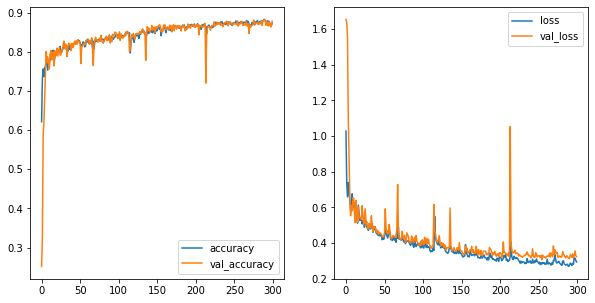

46/46 [==============================] - 0s 8ms/step - loss: 0.3289 - accuracy: 0.8663
maximum train acc :  0.882561981678009
maximum valid acc :  0.8828016519546509
test acc :  0.8662508726119995
test loss :  0.3288697898387909
f1 score :  0.7975839745408786
[[204   0   5   0   0   2]
 [  0  40  92   0   0   2]
 [  2   6 298   1   7   7]
 [  1   0   0  23   0   2]
 [  3   0  39   0  86   9]
 [  0   0  10   2   3 599]]


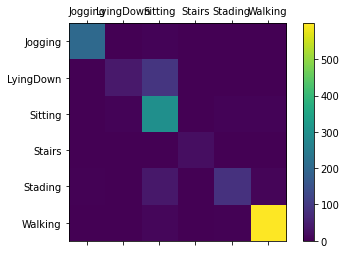

In [ ]:
# fix the random seed
# seed_sum = 42
# np.random.seed(seed_sum)
# rn.seed(seed_sum)
# tf.random.set_seed(seed_sum)

TIME_PERIODS = 200
STEP = 200
N_FEATURES = 3


# 80%, 10%, 10%로 set 나누기
x_train, x_val, y_train, y_val = train_test_split(origianl_x, original_y, test_size=0.2, stratify=original_y)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, stratify=y_val)

history, model = clssifier_without_ae(x_train, y_train, x_val, y_val)
        
model.load_weights("SAEwithout.h5")
test_results = model.evaluate(x_test, y_test)

print("maximum train acc : ", max(history.history["accuracy"]))
print("maximum valid acc : ", max(history.history["val_accuracy"]))
print("test acc : ", test_results[1])
print("test loss : ", test_results[0])


y_pred = model.predict([x_test])
score = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average="macro")
print("f1 score : ", score)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

label = ["Jogging", "LyingDown", "Sitting", "Stairs", "Stading", "Walking"]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation="nearest")
fig.colorbar(cax)
ax.set_xticklabels(['']+label)
ax.set_yticklabels(['']+label)
plt.show()